In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt

path = '/media/robert/Data_Storage/Data/Ionization/MultizoneBeamCombining/FirstAttempt/'
lam = 0.8
tau = 35.

In [2]:
pulseParams = {
    'Nt' : 2**6,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
}
pulseNx = 2**11
pulseNy = 2**11
pulseX = 3e4
pulseY = 3e4

beamNx = 2**12
beamNy = 2**12
beamX = 6e4
beamY = 6e4

plasmaParams = {
    'Nx' : pulseNx,
    'Ny' : pulseNy,
    'Nz' : 2**8,
    'X' : pulseX,
    'Y' : pulseY,
    'Z' : 2.0e6,
    'n0' : 0.1,
    'atom' : ionization.Ar,
    'path' : path,
    'load' : False,
    'cyl' : True
}

In [3]:
# Create the desired intensity profile
ion = {'atom' : ionization.Ar,
       'tau' : tau,
       'type' : 'gaussian'}
z0 = 2.75e6
zf = 100e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 100000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, 4, 0.50, zf)
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(z/1e6, I)
plt.title('Intensity profile')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'I ($10^{14}W/cm^2$)')
plt.xlim([0, 4]);

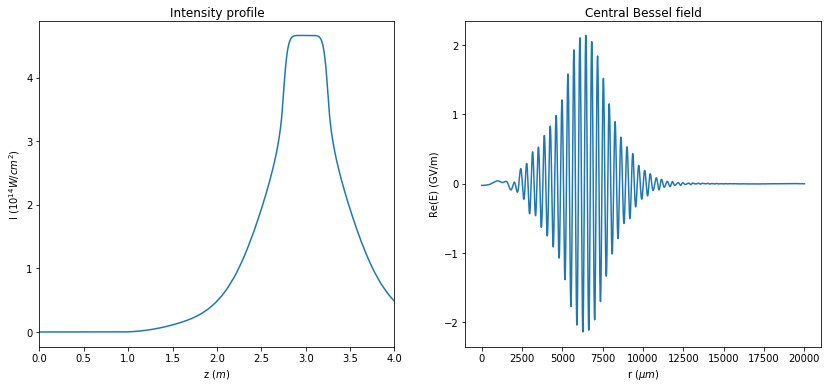

In [4]:
# Create the input field for the central mode with the ramps
params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : 140,
    'lam' : lam
}
rJ0, EJ0 = bessel.bessel_expansion(params, z, I)
plt.subplot(122)
plt.plot(rJ0, EJ0.real)
plt.title('Central Bessel field')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel('Re(E) (GV/m)')
plt.show()

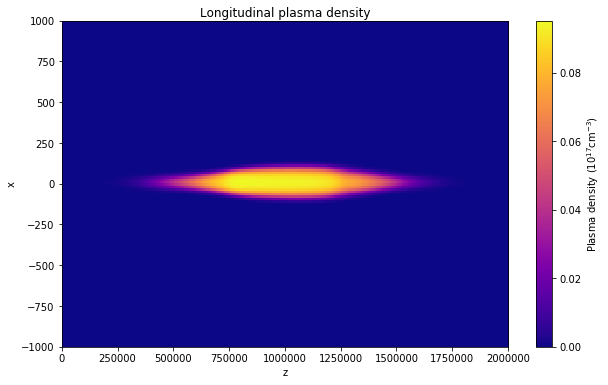

In [5]:
# Calculate the plasma density for the central mode
multiJ0 = 1.1
pulseParams['name'] = 'J0Beam'
pulseParams['order'] = 0
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['r'] = rJ0
pulseParams['E'] = multiJ0 * EJ0
beam = laserbeam.RadialLaser(pulseParams)
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                     beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
beam.propagate(2.0e6, 1.0) # propagate to the start of the plasma
pulseParams['name'] = 'J0Pulse'
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['r'] = beam.x
pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
pulse = laserpulse.RadialPulse(pulseParams)
plasmaParams['name'] = 'Plasma0'
argon = plasma.UniformPlasma(plasmaParams)
interactions.pulse_plasma(pulse, argon)
argon.plot_long_density_center(lim=[-1000, 1000])

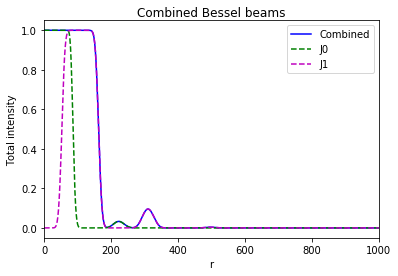

In [10]:
# Determine the strength of the first order mode
coef = [0.5, 0.9]
order = [0, 1]
R = [140, 140] #140 to limit refraction
r = np.linspace(0, 1e3, 1000)
ne, nj = bessel.multimode_transverse_estimate(r, ion, coef, order, R)
plt.plot(r, ne, 'b', r, nj[0, :], 'g--', r, nj[1, :], 'm--')
plt.title('Combined Bessel beams')
plt.xlabel('r')
plt.ylabel('Total intensity')
plt.legend(['Combined', 'J0', 'J1'])
plt.xlim([0, 1000])
plt.show()

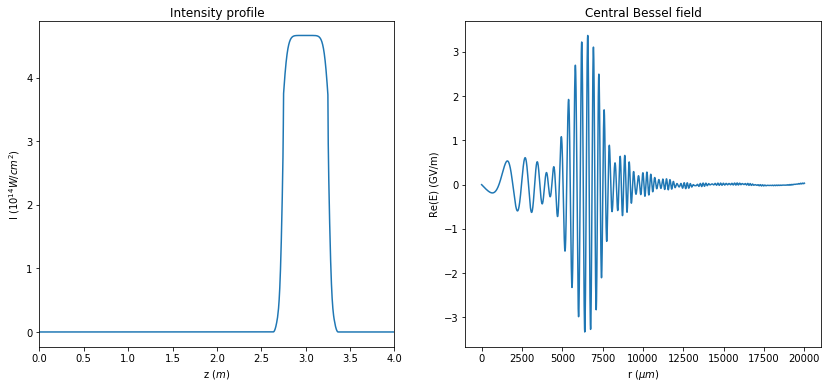

In [18]:
# Create the intensity profile with short ramps
sigmaIn = 1e4
sigmaOut = 1e4
z1, I1 = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, 4, 0.50, zf)
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(z1/1e6, I1)
plt.title('Intensity profile')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'I ($10^{14}W/cm^2$)')
plt.xlim([0, 4])
# Create the input field for the first order on the second lens
params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : R[1],
    'lam' : lam
}
rJ1, EJ1 = bessel.bessel_expansion(params, z1, I1, order[1])
EJ1 += coef[1]*EJ1
plt.subplot(122)
plt.plot(rJ1, EJ1.real)
plt.title('Central Bessel field')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel('Re(E) (GV/m)')
plt.show()

Power: 1.12048312078


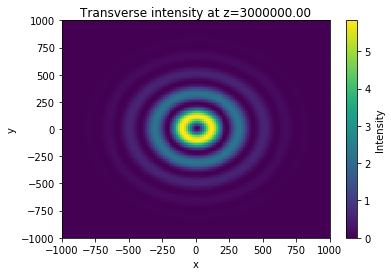

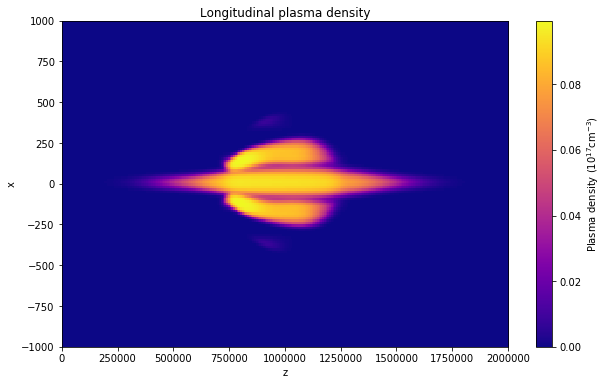

In [19]:
# Calculate the plasma density for the first order mode
multiJ1 = 1.0
pulseParams['name'] = 'J1Beam'
pulseParams['order'] = order[1]
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['r'] = rJ1
pulseParams['E'] = multiJ1 * EJ1
beam = laserbeam.RadialLaser(pulseParams)
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                     beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
beam.propagate(2.0e6, 1.0) # propagate to the start of the plasma
pulseParams['name'] = 'J1Pulse'
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['r'] = beam.x
pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
pulse = laserpulse.RadialPulse(pulseParams)
beam.propagate(1.0e6, 1.0) # test to make sure the beam looks correct
beam.plot_current_intensity(lim=[-1000, 1000])
plasmaParams['sourcePath'] = path
plasmaParams['sourceName'] = 'Plasma0'
plasmaParams['name'] = 'Plasma1'
argon = plasma.ExistingPlasma(plasmaParams)
interactions.pulse_plasma(pulse, argon)
argon.plot_long_density_center(lim=[-1000, 1000])